# Tutorial 

**Note**: This guide assumes you have installed [gemelli](https://github.com/biocore/gemelli).


## Introduction 

In this tutorial you will learn how to interpret and perform Robust Aitchison PCA. The focus of this tutorial is compositional beta diversity. There are many beta diversity metrics that have been proposed, all with varying benefits on varying data structures. However, presence/absence metric often prove to give better results than those that rely on abundances (i.e. unweighted vs. weighted UniFrac). One component of this phenomenon is the interpretation of relative abundances can provide spurious results (see [the differential abundance analysis introduction](https://docs.qiime2.org/2019.1/tutorials/gneiss/). One solution to this problem is to use a compositional distance metric such as Aitchison distance. 


As a toy example let’s build three taxa. These three taxa represent common distributions we see in microbiome datasets. Where the first taxon is increasing exponentially across samples, this is a trend that we would be interested in. However, taxon 2 and 3 have much higher counts and taxon 3 is randomly fluctuating across samples.  

![](//forum-qiime2-org.s3.dualstack.us-west-2.amazonaws.com/original/2X/7/72ebdf6a3303ce0a5850ce52a46befac564cc26d.png)

In our distances below we have Euclidean, Bray-Curtis, Jaccard, and Aitchison distances (from left to right). We can see that the abundance based metrics Euclidean and Bray-Curtis are heavily influenced by the abundance of taxon 3 and seem to randomly fluctuate. In the presence/absence metric, Jaccard, we see that the distance saturates to one very quickly. However, in the Aitchison distance we see a linear curve representing taxon 1. The reason the distance is linear is because Aitchison distance relies on log transforms (the log of an exponential taxon 1 is linear). 


![](//forum-qiime2-org.s3.dualstack.us-west-2.amazonaws.com/original/2X/b/bc002a51edcd3e34cba1874a6aa97d7d08b6c0b5.png)

From this toy example, it is clear that Aitchison distance better accounts for the proportions. However, we made the unrealistic assumption in our toy example that there were no zero counts. In real microbiome datasets there are a large number of zeros (i.e. sparsity). Sparsity complicates log ratio transformations because the log-ratio of zero is undefined. To solve this pseudo counts, that can skew results, are commonly used (see [Naught all zeros in sequence count data are the same](https://www.biorxiv.org/content/10.1101/477794v1)). 

Robust Aitchison PCA solves this problem in two steps:

**1.** Compostional preprocessing using the centered log ratio transform on only the non-zero values of the data (no pseudo count)

![](//forum-qiime2-org.s3.dualstack.us-west-2.amazonaws.com/original/2X/4/43fe1323791b5cea419e0973b8983621dbf31a20.gif)

![](//forum-qiime2-org.s3.dualstack.us-west-2.amazonaws.com/original/2X/1/13b8c6f415d6ab10c81dec1a27f1f24079be398f.gif)

**2.** Dimensionality reduction through Robust PCA on only the non-zero values of the data ( [matrix completion]( https://arxiv.org/pdf/0906.2027.pdf)). 

![](//forum-qiime2-org.s3.dualstack.us-west-2.amazonaws.com/original/2X/a/a327d5600f68b96457c227c660f533e94ee68341.gif)


To demonstrate this in action we will run an example dataset below, where the output can be viewed as a compositional biplot through emperor. 

## Example 


In this example we will use Robust Aitchison PCA via gemelli on the “Moving Pictures” dataset. The dataset consists of human microbiome samples from two individuals at four body sites at five timepoints, the first of which immediately followed antibiotic usage ([Caporaso et al. 2011](https://www.ncbi.nlm.nih.gov/pubmed/21624126)). The tables needed for this tutorial are provided below:



##### Table [download](https://github.com/biocore/DEICODE/blob/master/ipynb/tutorials/qiime2-moving-pictures-tutorial/table.biom?raw=true)
**save as:** table.biom 

##### Sample Metadata [download](https://github.com/biocore/DEICODE/blob/master/ipynb/tutorials/qiime2-moving-pictures-tutorial/sample-metadata.tsv?raw=true)
**save as:** sample-metadata.tsv

##### Feature Metadata  [download](https://github.com/biocore/DEICODE/blob/master/ipynb/tutorials/qiime2-moving-pictures-tutorial/taxonomy.tsv?raw=true)
**save as:** taxonomy.tsv


In [1]:
!cd qiime2-moving-pictures-tutorial

Using table.biom in [biom format](http://biom-format.org/), a raw count table, we will generate our beta diversity ordination file. There are a few parameters to gemelli that we may want to consider. The first is filtering cutoffs, these are `min-feature-count`, `min-sample-count`, and `min-feature-frequency`. Both min-feature-count and min-sample-count accept integer values and remove feature or samples, respectively, with sums below this cutoff. The feature cut-off is useful in the case that features with very low total counts among all samples represent contamination or chimeric sequences. The sample cut off is useful for the case that some sample received very few reads relative to other samples. The min-feature-frequency can be useful to remove features that only appear in a small portion of samples, which may be difficult to further asses using tools like [Qurro](https://github.com/biocore/qurro).

**Note:** it is _not_ recommended to bin your features by taxonomic assignment (i.e. by genus level). 
**Note:** it is _not_ recommended to rarefy your data before using gemelli. 

The other main parameter of the gemelli is the number of components to use through `n-components` (i.e. the rank). gemelli relies on a low-rank assumption and therefore it is recommended to choose a value between 2 and 10. 

Now that we understand the acceptable parameters, we are ready to run gemelli.  


In [2]:
%%capture
!gemelli rpca \
    --in-biom qiime2-moving-pictures-tutorial/table.biom \
    --output-dir qiime2-moving-pictures-tutorial/standalone-cli

The same command can be run using the python API through the following:

In [2]:
from biom import load_table
from gemelli.rpca import rpca

# import the data table
table = load_table('qiime2-moving-pictures-tutorial/table.biom')
# perform RPCA
ordination, distance = rpca(table, min_sample_count=500)


/Users/cameronmartino/Dropbox/bin/gemelli/gemelli/preprocessing.py:426: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


To ensure the impact of differences in sequencing depth or sample sum differences are not influencing the sample distances an additional QC step can be run. To do this we will first rarefy the data at the same depth as the sample sum cut-off used above. Then we will run mantel tests between the rarefied and unrarefied distance vs. the absolute difference in sample sums.  This can be done easily through the following:

In [8]:
from gemelli.utils import qc_rarefaction

rare_ordination, rare_distance = rpca(table.copy().subsample(500))
t, p = qc_rarefaction(table, rare_distance, distance)
(t, p)

(-0.5204080617994011, 0.6064763616568878)

We can see here that the difference between the rarefied distance vs. unrarefied distance in the correlation to the absolute difference in sample sums is non-significant. If it was significant you would need to continue on using _only_ the rarefied results but since it is not here we will continue with the unrarefied. If you are unsure about your results, RPCA works with rarefied data and you continue with that.

The output of the standalone tool is two-fold an [OrdinationResults](http://scikit-bio.org/docs/0.5.1/generated/generated/skbio.stats.ordination.OrdinationResults.html) file and a [DistanceMatrix](http://scikit-bio.org/docs/0.5.1/generated/generated/skbio.stats.distance.DistanceMatrix.html) both in [scikit-bio](http://scikit-bio.org/docs/0.5.1/index.html) format. Both the output files can both be imported and visualized from the standalone command or directly used from the python API. First we will plot the ordination biplot to explore sample separation and the features driving the difference.

First we need to import the metadata.

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from assets.plotting_helper import biplot
%matplotlib inline

# import the sample metadata
mf = pd.read_csv('qiime2-moving-pictures-tutorial/sample-metadata.tsv',
                 sep='\t', index_col=0).drop(['#q2:types'], axis=0)
# import the taxonomy metadata
tf = pd.read_csv('qiime2-moving-pictures-tutorial/taxonomy.tsv',
                 sep='\t', index_col=0)
# view
mf.head(2)

,BarcodeSequence,LinkerPrimerSequence,BodySite,Year,Month,Day,Subject,ReportedAntibioticUsage,DaysSinceExperimentStart,Description
#SampleID,,,,,,,,,,
L1S8,AGCTGACTAGTC,GTGCCAGCMGCCGCGGTAA,gut,2008,10,28,subject-1,Yes,0,subject-1.gut.2008-10-28
L1S57,ACACACTATGGC,GTGCCAGCMGCCGCGGTAA,gut,2009,1,20,subject-1,No,84,subject-1.gut.2009-1-20


We can view the ordination loadings through the `ordination` result of type OrdinationResults.

In [6]:
# the sample loadings
spca_df = ordination.samples
spca_df.head(2)

,PC1,PC2,PC3,PC4,PC5
L1S105,-0.090263,0.202402,0.293835,0.273304,-0.118611
L1S140,-0.351046,0.041167,-0.048862,-0.086615,-0.107419


In [7]:
# the feature loadings
fpca_df = ordination.features
fpca_df.head(2)

,PC1,PC2,PC3,PC4,PC5
4b5eeb300368260019c1fbc7a3c718fc,-0.076566,0.021455,0.272938,0.357056,-0.256331
fe30ff0f71a38a39cf1717ec2be3a2fc,0.108060,-0.240542,-0.170898,-0.053301,-0.221769


Next we can directly add the metadata to the loadings.

In [8]:
# merge the sample metadata and loadings
spca_df = pd.concat([spca_df, mf.reindex(spca_df.index)],
                    axis=1, sort=True)
spca_df.head(2)


,PC1,PC2,PC3,PC4,PC5,BarcodeSequence,LinkerPrimerSequence,BodySite,Year,Month,Day,Subject,ReportedAntibioticUsage,DaysSinceExperimentStart,Description
L1S105,-0.090263,0.202402,0.293835,0.273304,-0.118611,AGTGCGATGCGT,GTGCCAGCMGCCGCGGTAA,gut,2009,3,17,subject-1,No,140,subject-1.gut.2009-3-17
L1S140,-0.351046,0.041167,-0.048862,-0.086615,-0.107419,ATGGCAGCTCTA,GTGCCAGCMGCCGCGGTAA,gut,2008,10,28,subject-2,Yes,0,subject-2.gut.2008-10-28


In [9]:
# merge the feature metadata and loadings
fpca_df = pd.concat([fpca_df, tf.reindex(fpca_df.index)],
                    axis=1, sort=True)
fpca_df.head(2)


,PC1,PC2,PC3,PC4,PC5,Taxon,Confidence
0160e14a78b18b903618f11bc732746e,0.043439,-0.028137,0.065841,0.186956,0.022391,k__Bacteria; p__Verrucomicrobia; c__Verrucomic...,1.000000
01b99cb344ed2530f7d80897ffe257a9,0.008712,0.005172,-0.003146,-0.001097,-0.005254,k__Bacteria; p__Proteobacteria; c__Betaproteob...,0.777604


Now we will plot both loadings as a biplot by using seaborn and matplotlib. To do this we will first make a plotting helper function called `biplot` which is located in the assets directory.

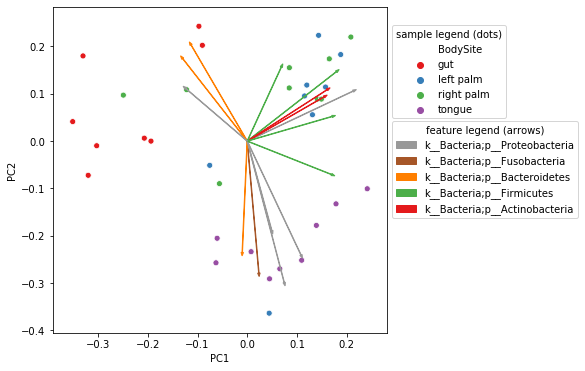

In [10]:
fig, ax = plt.subplots(1,1, figsize=(6, 6))

# plot the biplot
ax = biplot('PC1', 'PC2', spca_df,
            fpca_df, 'BodySite', ax)

plt.show()


Biplots are exploratory visualization tools that allow us to represent the features (i.e. taxonomy or OTUs)  that strongly influence the principal component axis as arrows. The interpretation of the compositional biplot differs slightly from classical biplot interpretation. The important features with regard to sample clusters are not a single arrow but by the log ratio between features represented by arrows pointing in different directions.


From this visualization we noticed that BodySite seems to explain the clusters well. We can run [PERMANOVA](https://docs.qiime2.org/2019.1/plugins/available/diversity/beta-group-significance/) on the distances to get a statistical significance for this. 

In [11]:
from skbio.stats.distance import permanova

permanova(distance, mf['BodySite'])

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      34
number of groups                  4
test statistic              1.67627
p-value                       0.057
number of permutations          999
Name: PERMANOVA results, dtype: object

Indeed we can now see that the clusters we saw in the biplot are significant.

We can see from the biplot and PERMANOVA results that gut is very different from the skin samples. Next we can use [qurro](https://github.com/biocore/qurro) to explore log-ratios of the microbes highlighted by gemelli. For more about why log-ratios are useful you may want to read ["Establishing microbial composition measurement standards with reference frames"](https://www.nature.com/articles/s41467-019-10656-5).

In [15]:
%%capture
!qurro\
    --ranks qiime2-moving-pictures-tutorial/standalone-cli/ordination.txt\
    --table qiime2-moving-pictures-tutorial/table.biom\
    --sample-metadata qiime2-moving-pictures-tutorial/sample-metadata.tsv\
    --feature-metadata qiime2-moving-pictures-tutorial/taxonomy.tsv\
    --output-dir qiime2-moving-pictures-tutorial/qurro-standalone

Two taxa groups whose arrows seem to be directly opposed with relation to the BodySite grouping is Bacteroides (associated with gut) and Streptococcus (associated with skin and oral). We can use Qurro to explore this relationship. To make a log-ratio we can filter by taxa who contain Bacteroides in the numerator and Streptococcus in the denominator of the log-ratio. Those features will then be summed according to thier taxonomic labels and used in the log-ratio. In Qurro the axis one loadings (or another axis) from gemelli are highlighted by if they are contained in the numerator or denominator. The log-ratio plot is contained on the left and can be visualized as a scatter or box-plot. From this it is clear these taxa can separate our BodySite groupings. 

![](etc/img16.png)


A tsv file with the log-ratios can be exported and a t-test by BodySite on the log-ratios could confirm this observation by using the `Export current sample plot data` button. 

In [13]:
import itertools
from scipy.stats import ttest_ind

# import the taxonomy metadata
lrdf = pd.read_csv('qiime2-moving-pictures-tutorial/sample_plot_data.tsv',
                   sep='\t', index_col=0).dropna(subset=['Current_Natural_Log_Ratio'])
# split data by BodySite
lrs = {type_:df_.Current_Natural_Log_Ratio
       for type_, df_ in lrdf.groupby('BodySite')}
# get all combos
ids_ = list(itertools.combinations(lrs.keys(), 2))
# take t-test
tst = pd.DataFrame({(id1_, id2_):ttest_ind(lrs[id1_], lrs[id2_])
                    for id1_, id2_ in ids_},
                   ['test-stat','p-value']).T
tst.index.names = ['group one vs.', 'group two']
# view results
tst


test-stat       p-value
group one vs. group two                          
gut           left palm    9.943842  3.749890e-06
              right palm   3.385889  6.933597e-03
              tongue      20.744948  6.574794e-09
left palm     right palm  -1.181070  2.587322e-01
              tongue       1.526182  1.528810e-01
right palm    tongue       1.893318  8.078723e-02

From this we can see that gut vs. skin and oral is significantly different using this log-ratio but skin vs. oral is not.